In [1]:
############ package loading ##############
%matplotlib inline
import torch
from torch import nn
import numpy as np
from torch.utils import data
from io import StringIO
import random
from d2l import torch as d2l
from matplotlib import pyplot as plt
import torchvision
import re
import os
import glob
import pandas as pd

In [3]:
############ useful functions ##############
def plot(g_struct):
    ax = plt.figure(figsize=(10,15)).add_subplot(projection='3d')
    ax.voxels(g_struct, edgecolor='None')
    ax.set_xlim(0,6)
    ax.set_ylim(0,6)
    ax.set_zlim(0,6)

def choose_data_plot_channel_1(main_id,batch_id,data,limit):
    g_struct = data.copy()
    g_struct[main_id,batch_id,1,:,:,:][g_struct_s[main_id,batch_id,1,:,:,:]<limit] = 1
    g_struct[main_id,batch_id,1,:,:,:][g_struct_s[main_id,batch_id,1,:,:,:]>limit] = 2
    print(sum(sum(sum(g_struct[main_id,batch_id,1,:,:,:]-1))))
    plot(g_struct[main_id,batch_id,1,:,:,:]-1)
    
def choose_data_plot_channel_0(main_id,batch_id,data,limit):
    g_struct = data.copy()
    g_struct[main_id,batch_id,0,:,:,:][g_struct_s[main_id,batch_id,0,:,:,:]<limit] = 2
    g_struct[main_id,batch_id,0,:,:,:][g_struct_s[main_id,batch_id,0,:,:,:]>limit] = 1
    print(sum(sum(sum(g_struct[main_id,batch_id,0,:,:,:]-1))))
    plot(g_struct[main_id,batch_id,0,:,:,:]-1)
    
def transfer_3d_gan_out_limit_large(x_out):
    x_copy = x_out.copy()
    x_new = np.zeros((6,6,6))
    for i in range(56):
        max_index = np.unravel_index(np.argmax(x_copy, axis=None), x_copy.shape)
        x_copy[max_index]=0
        x_new[max_index]=1
    return x_new


def choose_data_plot_whole(data,limit_1,limit_2):
    g_struct = data.copy()
    g_struct[:,:,1,:,:,:][g_struct_s[:,:,1,:,:,:]<limit_1] = 1
    g_struct[:,:,1,:,:,:][g_struct_s[:,:,1,:,:,:]>limit_1] = 2
    g_struct[:,:,0,:,:,:][g_struct_s[:,:,0,:,:,:]<limit_2] = 1
    g_struct[:,:,0,:,:,:][g_struct_s[:,:,0,:,:,:]>limit_2] = 2
    return g_struct

def choose_data_plot_limit(main_id,batch_id,data):
    g_struct = data.copy()
    data_for_plot = transfer_3d_gan_out_limit_large(g_struct_s[main_id,batch_id,1,:,:,:])
    print(sum(sum(sum(data_for_plot))))
    plot(data_for_plot)

def choose_data_plot_limit_1(main_id,batch_id,data):
    g_struct = data.copy()
    data_for_plot = transfer_3d_gan_out_limit_large(g_struct_s[main_id,batch_id,0,:,:,:])
    print(sum(sum(sum(data_for_plot))))
    plot(data_for_plot)

def transfer_gan_out_1_channel(data):
    num_samples = data.size(0)
    bsz = data.size(1)
    g_struct = data.copy()
    for i in range(num_samples):
        for j in range(bsz):
            g_struct[i,j,0,:,:,:] = transfer_3d_gan_out_limit_large(g_struct[i,j,0,:,:,:])
    g_struct += 1
    return g_struct

def transfer_gan_out_2_channel(data):
    num_samples = data.size(0)
    bsz = data.size(1)
    g_struct = data.copy()
    for i in range(num_samples):
        for j in range(bsz):
            g_struct[i,j,1,:,:,:] = transfer_3d_gan_out_limit_large(g_struct[i,j,1,:,:,:])
            g_struct[i,j,0,:,:,:] = 1-g_struct[i,j,1,:,:,:]
    g_struct += 1
    return g_struct



In [2]:
############ data loading ##############
S_path = './sample/'
obj = 'lg'
dataset = 'random'
path_s = S_path+'sample_'+obj+'_'+dataset+'.pt'
g_struct_s = torch.load(path_s)
num_samples = g_struct_s.size(0)
bsz = g_struct_s.size(1)
D_channel = g_struct_s.size(2)
if D_channel == 1:
    surr_model = torch.load('./model/surr_model/1_channel_model/1_channel_sur_model.pt',map_location=torch.device('cpu'))
else:
    surr_model = torch.load('./model/surr_model/2_channel_model/2_channel_sur_model.pt',map_location=torch.device('cpu'))

g_struct_s.size()

(1000, 8, 1, 6, 6, 6)
(100, 8, 2, 6, 6, 6)


In [ ]:
# Deal with data and calculate moduli
if D_channel == 1:
    data_processed = transfer_gan_out_1_channel(g_struct_s)
else:
    data_processed = transfer_gan_out_2_channel(g_struct_s)
data_processed = data_processed.float()
# print whatever moduli you want to check
print(surr_model(data_processed[3,:,:,:,:,:])
# calculate all the moduli if has not been calculated
if data_flag == False:
    moduli_path = S_path+'moduli_for_sample_'+obj+'_'+dataset+'.pt'
    moduli_for_all = []
    for i in range(num_samples):
        moduli_for_all.append(surr_model(data_processed[i,:,:,:,:,:]))
    moduli_for_all = torch.stack(moduli_for_all,dim=0)
    torch.save(moduli_for_all,moduli_path)
    data_flag = True

tensor([[1.0405, 1.4809, 1.1467],
        [1.1603, 1.2262, 1.1821],
        [1.2357, 1.1724, 1.3443],
        [1.1325, 1.4029, 1.2760],
        [1.4649, 1.3420, 1.1898],
        [1.2064, 1.2947, 1.3051],
        [1.2076, 1.3106, 1.3388],
        [1.4297, 1.1688, 1.3437]], grad_fn=<AddmmBackward0>)
tensor([1.3106, 1.2314, 1.2660], grad_fn=<MeanBackward1>)
tensor([0.0149, 0.0096, 0.0065], grad_fn=<VarBackward0>)
tensor(1.2693, grad_fn=<MeanBackward1>)
tensor(0.0148, grad_fn=<MeanBackward1>)


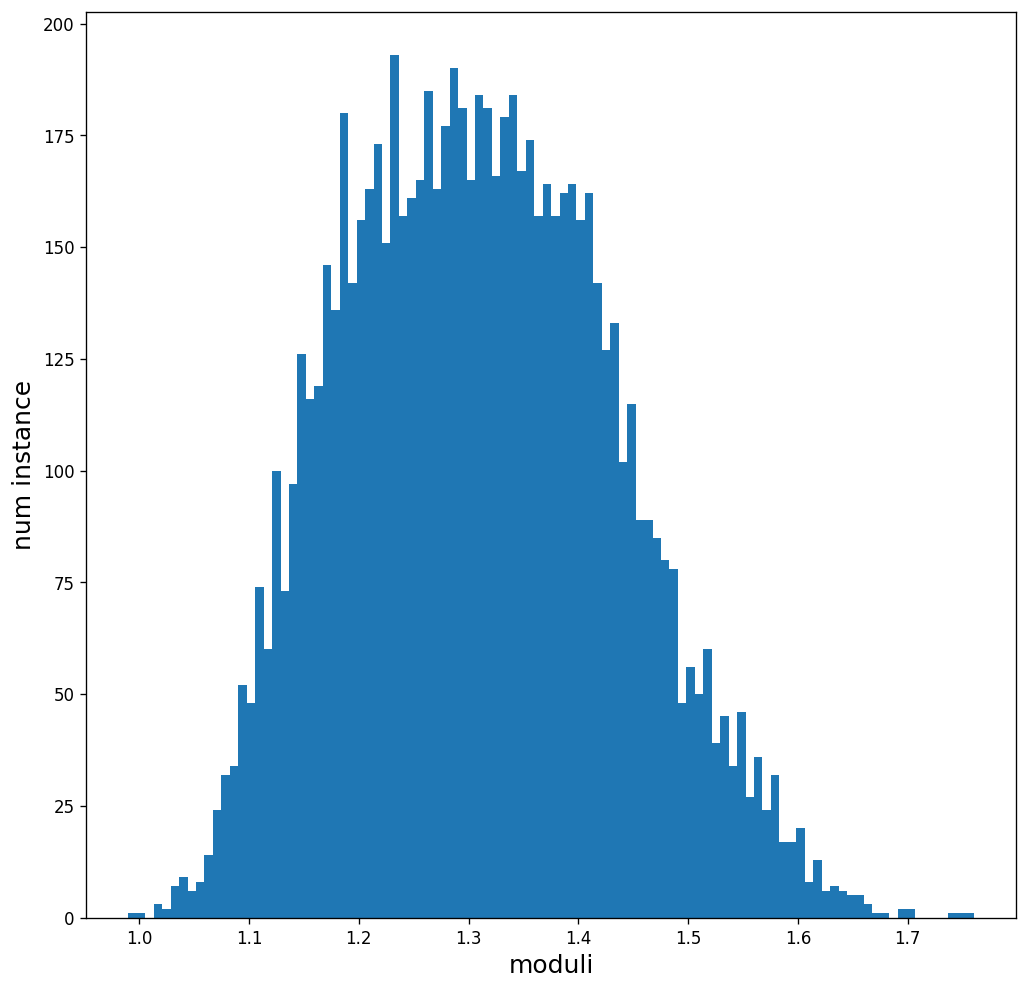

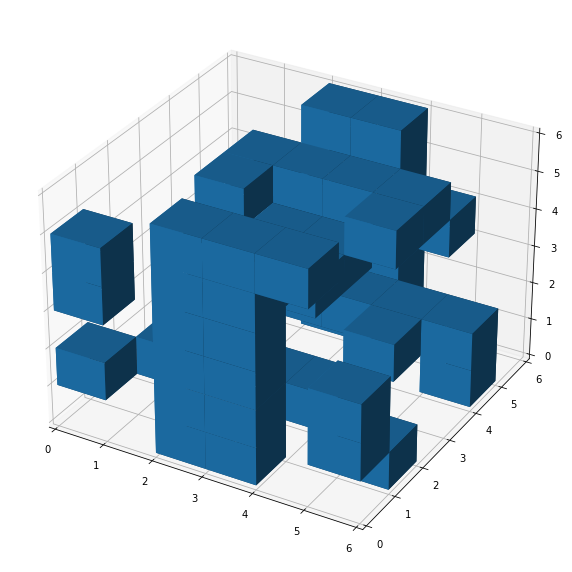

In [4]:
# print average and var
moduli_reshape = torch.reshape(moduli_for_all,(num_samples*bsz,3))
mean_moduli_3_direction = torch.mean(moduli_reshape,dim=0) # check large moduli performance
var_moduli_3_direction = torch.var(moduli_reshape,dim=0) # check large moduli performance
mean_var_moduli_all = torch.mean(torch.var(moduli_reshape,dim=1),dim=0) # check symm moduli performance
mean_moduli = torch.mean(mean_moduli_3_direction,dim=0) # check large moduli performance
print(mean_moduli_3_direction)
print(var_moduli_3_direction)
print(mean_moduli)
print(mean_var_moduli_all)

# plot moduli performance for different axis
moduli_for_plot = np.array(moduli_reshape[:,0].detach().cpu())
fig = plt.figure(figsize=(10,10),dpi=120)
plt.hist(moduli_for_plot,100)
plt.xlabel('moduli',fontsize = 15)
plt.ylabel('num instance',fontsize = 15)
plt.show()

# plot whatever you want
plot(data_processed[1,6,0,:,:,:])